# Import all the libraries

In [2]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

from sklearn.preprocessing import *
from sklearn.linear_model import *

import matplotlib.pyplot as plt
from darts import *
from darts.dataprocessing.transformers import *
from darts.models import *
from darts.metrics import *
from darts.datasets import *
from darts.utils.statistics import *
from darts.utils.timeseries_generation import *
from darts.utils.missing_values import fill_missing_values
from backtesting.test import EURUSD


# Load the TimeSeries dataframe

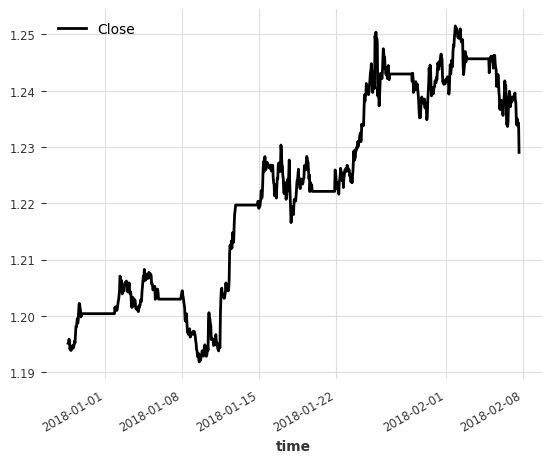

In [3]:
data = EURUSD.copy()
data = data[['Close']]
# extract only the last 1 month of data
data = data.iloc[-24*7*4:]

# data.plot()
eur_usd_series = TimeSeries.from_dataframe(data, value_cols=['Close'], freq='H',fill_missing_dates=True)
eur_usd_series = fill_missing_values(eur_usd_series, method="ffill", limit_direction="forward")
eur_usd_series.plot()

# Classical Models

Training model XGBModel
model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) obtains MAPE: 0.26%


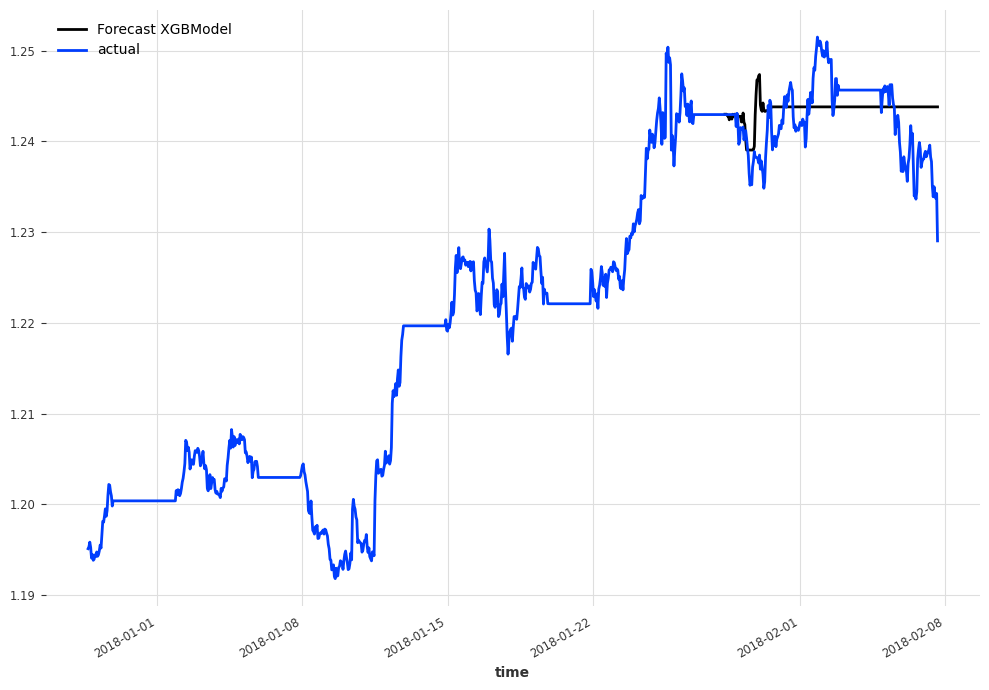

In [12]:
train, val = eur_usd_series.split_before(0.75)

models = {
    # "Theta": Theta(seasonality_period=24*7),
    # "ExponentialSmoothing": ExponentialSmoothing(seasonal_periods=24*7),
    # "LinearRegression": LinearRegressionModel(lags=24*7),
    # "BayesianRidge": RegressionModel(lags=24*7, model=BayesianRidge()),
    "XGBModel": XGBModel(lags=24*7),
    # "LightGBMModel": LightGBMModel(lags=24*7),
#     "DriftSeasonalEnsemble": RegressionEnsembleModel(
#     forecasting_models=[NaiveDrift(), NaiveSeasonal(24*7)], 
#     regression_train_n_points=200
# ),
}

fig = plt.figure(figsize=(10, 7))
for i, (name, model) in enumerate(models.items()):
    print("Training model %s" % name)
    model.fit(train)
    forecast = model.predict(len(val))
    forecast.plot(label="Forecast {}".format(name))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))

eur_usd_series.plot(label="actual")  
fig.tight_layout()
plt.show()

# Classical Models With MinMaxScaler

Training model Theta
model Theta(seasonality_period=168) obtains MAPE: 0.32%
Training model ExponentialSmoothing
model ExponentialSmoothing(seasonal_periods=168) obtains MAPE: 0.66%
Training model LinearRegression
model LinearRegression() obtains MAPE: 0.76%


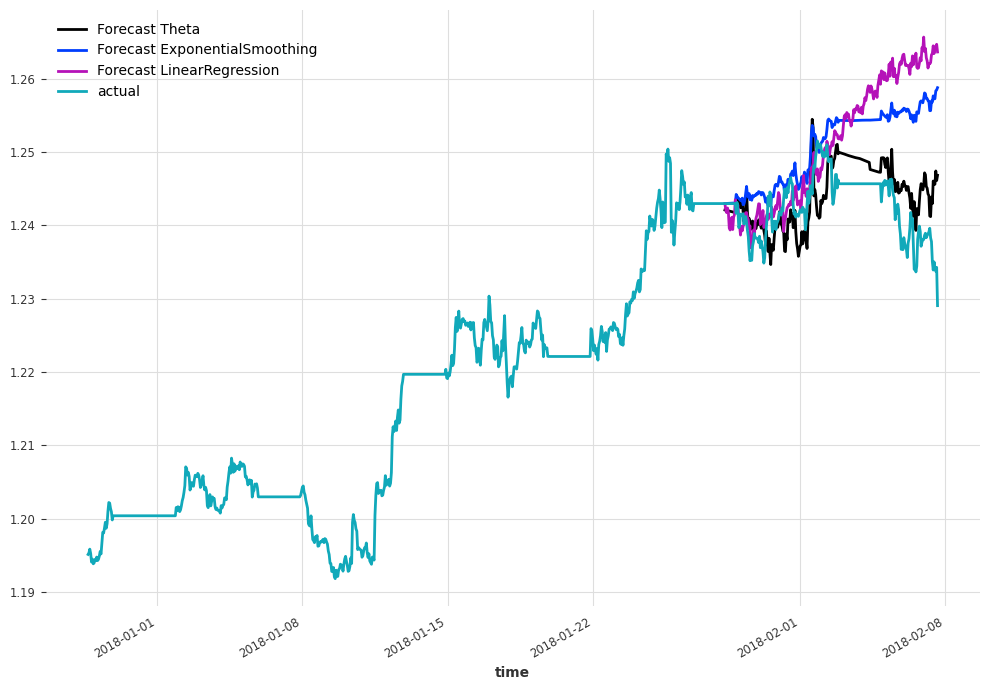

In [13]:
train, val = eur_usd_series.split_before(0.75)

transformer = Scaler(MinMaxScaler(feature_range=(0.1, 1)))
train = transformer.fit_transform(train)
val = transformer.transform(val)


models = {
    "Theta": Theta(seasonality_period=24*7),
    "ExponentialSmoothing": ExponentialSmoothing(seasonal_periods=24*7),
    "LinearRegression": LinearRegressionModel(lags=24*7),
}

fig = plt.figure(figsize=(10, 7))
for i, (name, model) in enumerate(models.items()):
    print("Training model %s" % name)
    model.fit(train)
    forecast = model.predict(len(val))
    forecast_original = transformer.inverse_transform(forecast)
    forecast_original.plot(label="Forecast {}".format(name))
    
    val_original = transformer.inverse_transform(val)
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val_original, forecast_original)))

eur_usd_series.plot(label="actual")  
fig.tight_layout()
plt.show()

# Classical Models with PowerTransformer

Training model Theta
model Theta(seasonality_period=168) obtains MAPE: 0.48%
Training model ExponentialSmoothing
model ExponentialSmoothing(seasonal_periods=168) obtains MAPE: 0.30%
Training model LinearRegression
model LinearRegression() obtains MAPE: 1.06%


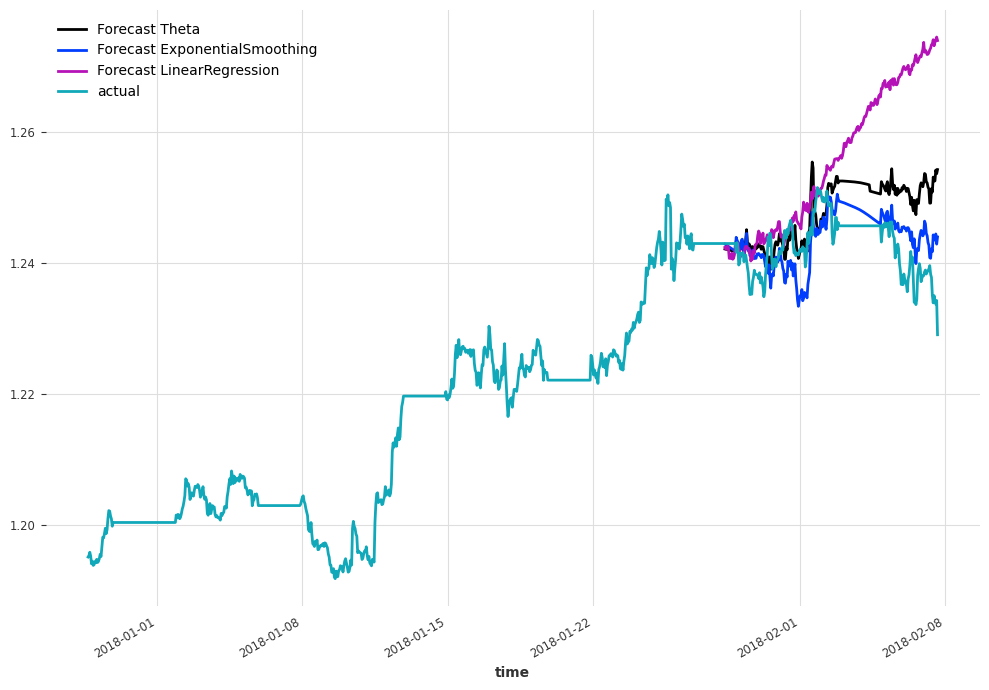

In [14]:
train, val = eur_usd_series.split_before(0.75)

transformer = BoxCox()
train = transformer.fit_transform(train)
val = transformer.transform(val)


models = {
    "Theta": Theta(seasonality_period=24*7),
    "ExponentialSmoothing": ExponentialSmoothing(seasonal_periods=24*7),
    "LinearRegression": LinearRegressionModel(lags=24*7),
}

fig = plt.figure(figsize=(10, 7))
for i, (name, model) in enumerate(models.items()):
    print("Training model %s" % name)
    model.fit(train)
    forecast = model.predict(len(val))
    forecast_original = transformer.inverse_transform(forecast)
    forecast_original.plot(label="Forecast {}".format(name))
    
    val_original = transformer.inverse_transform(val)
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val_original, forecast_original)))

eur_usd_series.plot(label="actual")  
fig.tight_layout()
plt.show()